In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import log_loss, roc_curve, roc_auc_score, zero_one_loss, classification_report, confusion_matrix, accuracy_score
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt
from matplotlib import pyplot
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline, make_pipeline
import random
from numpy.random import seed
import tensorflow as tf

In [2]:
# function to reset all RNG's to seed 23
def reset_random_seeds():
   tf.random.set_seed(23) # tensorflow's seed
   np.random.seed(23) # numpy's seed
   random.seed(23) # python's seed

# import data
data = pd.read_csv (r'bank-additional\bank-additional-full.csv', sep = ';', engine= 'python')
#data = data.head(1000)
length = data.shape[0]
data.head()

# select variables
cats_to_use = ['age', 'default', 'contact', 'month', 'previous', 'poutcome', 'emp.var.rate', 'euribor3m', 'nr.employed', 'y']
data = data[cats_to_use]

# 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
#       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
#       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
#       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'

# save lists of categorical and numerical variables
cat_cols = ['default', 'contact', 'month', 'poutcome', 'y']
num_cols = ['age', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed']

# create column transformer to 1 one-hot-encode cat vars and 2 noralise num vars
ct = make_column_transformer(
    (OneHotEncoder(drop='first'), cat_cols), # drop first column (reference)
    (StandardScaler(), num_cols),
)

# transform base table (pandas df -> numpy array)
base = ct.fit_transform(data)

# convert base table to p.df for ease of use (numpy array -> pandas df)
base_temp = pd.DataFrame(base, columns=ct.get_feature_names_out().tolist())
base_temp

# seperate base table into X and y and convert to numpy array (base pandas df -> y numpy array + X numpy array)
y = base_temp['onehotencoder__y_yes'].values
X = base_temp.drop(columns=['onehotencoder__y_yes']).values

# save and check dimensions of X 
(X_length, X_vars) = X.shape
X_length, X_vars


(41188, 19)

In [ ]:
# create model and wrap into sklearn compatible classifier

train_features, test_features, train_targets, test_targets = train_test_split(X, y, test_size=0.2,
                                                                                  random_state=23)

# define hyperparameter search space
#max_depth = [1]
#n_estimators = range(1,1001, 50)
n_estimators = np.geomspace(1,200,num=20,dtype=int)
max_depth = range(1,16,3)
# create dictionary from search space
grid = dict(
    randomforestclassifier__max_depth=max_depth,
    randomforestclassifier__n_estimators=n_estimators
)

# create 10-fold cross validation generator
cv = KFold(n_splits=10)

# create imbalanced learn pipeline
imba_pipeline = make_pipeline(NearMiss(version=1), RandomForestClassifier(n_estimators= n_estimators ,random_state=23))

# create random searcher with 10-fold cv and start tuning process
model_grid = GridSearchCV(estimator=imba_pipeline, param_grid=grid, n_jobs=1, cv=cv, verbose=2, scoring='roc_auc')
grid_res = model_grid.fit(train_features, train_targets)

# summarise grid search info
bestScore = grid_res.best_score_
bestParams = grid_res.best_params_


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=1; total time=   1.1s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=1; total time=   1.1s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=1; total time=   1.1s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=1; total time=   1.0s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=1; total time=   1.0s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=1; total time=   1.0s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=1; total time=   1.0s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=1; total time=   1.0s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=1; total tim

[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=7; total time=   1.1s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=7; total time=   1.0s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=9; total time=   1.1s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=9; total time=   1.0s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=9; total time=   1.1s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=9; total time=   1.2s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=9; total time=   1.2s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=9; total time=   1.2s
[CV] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=9; total time=   1.0s
[CV] END randomforestclassifier__max_depth=1, randomfor

In [ ]:
print("[INFO] best score is {:.2f} using {}".format(bestScore, bestParams))

In [7]:
# train_features, test_features, train_targets, test_targets = train_test_split(features, y.ravel(), test_size=0.2,
#                                                                                   random_state=23)
# ensemble = RandomForestClassifier().fit(train_features, train_targets)


# #After the first run we make jumps of 100, 10 and lastly 1 for n_estimator

# param_grid = {'n_estimators': range(1,6001,1000),
#              'max_depth': [1,2,3,4,5,6,7,8,9]}
# grid = GridSearchCV(ensemble,param_grid,refit=True, scoring='roc_auc' ,verbose =2)
# grid.fit(train_features,train_targets)
# print(grid.best_estimator_)
# print(grid.best_params_)

# grid_predictions = grid_res.predict(test_features)
# print(confusion_matrix(test_targets,grid_predictions))
# print(classification_report(test_targets,grid_predictions))

In [17]:
#print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

In [14]:
# underfit test data

nm = NearMiss(version = 1)

X_res, y_res = nm.fit_resample(train_features, train_targets)

In [16]:
train_features.shape,X_res.shape

((32950, 19), (7506, 19))

1.0000000, train: 0.812, test: 0.665
8.0000000, train: 0.836, test: 0.647
15.0000000, train: 0.830, test: 0.657
22.0000000, train: 0.828, test: 0.659
29.0000000, train: 0.827, test: 0.666
36.0000000, train: 0.828, test: 0.662
43.0000000, train: 0.830, test: 0.657
50.0000000, train: 0.829, test: 0.660
57.0000000, train: 0.829, test: 0.659
64.0000000, train: 0.829, test: 0.660
71.0000000, train: 0.830, test: 0.659
78.0000000, train: 0.829, test: 0.659
85.0000000, train: 0.830, test: 0.659
92.0000000, train: 0.829, test: 0.660
99.0000000, train: 0.829, test: 0.661


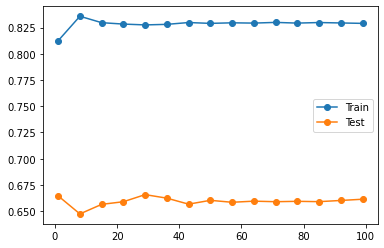

In [20]:
# define lists to collect scores
train_scores, test_scores = list(), list()
#Now we set our n_estimator and learning_rate to the optimal value found in the last grid search
nEstimator = 951

#Check for overfitting

# define the tree depths to evaluate
values = [i for i in range_with_floats(1, 101, 7)]
# evaluate a decision tree for each depth
for i in values:
    # configure the model
    model = RandomForestClassifier(n_estimators=i, max_depth = 5, random_state = 23).fit(
        X_res, y_res)
    # evaluate on the train dataset
    schatting = model.predict(X_res)
    train_acc = roc_auc_score(y_res, schatting)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_schatting = model.predict(test_features)
    test_acc = roc_auc_score(test_targets, test_schatting)
    test_scores.append(test_acc)
    # summarize progress
    print('%.7f, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

In [25]:
#Boosting the tree and predicting with ROC curve and classification reports
def random_forest(feature, targets, nEstimators):
    train_features, test_features, train_targets, test_targets = train_test_split(feature, targets, test_size=0.2,
                                                                                  random_state=23)
    ensemble = RandomForestClassifier(max_depth=maxDepth, n_estimators= nEstimators ,random_state=23)
    
    k = 10
    kf = KFold(n_splits=k, shuffle = True)

    
    dt_scores = cross_val_score(ensemble, train_features, train_targets, scoring ='roc_auc' ,cv = kf)
    print("mean cross validation score: {}".format(np.round(np.mean(dt_scores),3)))

    ensemble.fit(train_features, train_targets)
    predictions = ensemble.predict(test_features)
    
    print("Confusion Matrix:")
    print(confusion_matrix(test_targets, predictions))

    print("Classification Report")
    print(classification_report(test_targets, predictions))
    
    #Beginning the plotting of ROC-curve
    pred_prob = ensemble.predict_proba(test_features)
    fpr, tpr, thresh = roc_curve(test_targets, pred_prob[:,1], pos_label=1)
    
    #Plot roc curves
    plt.plot(fpr, tpr, linestyle='--',color='orange', label='Random Forest')

    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show();
    
    #AUC Score
    auc_score = roc_auc_score(test_targets, pred_prob[:,1])
    print("AUC Score: " + str(np.round(auc_score , 3)))

mean cross validation score: 0.935
Confusion Matrix:
[[887  48]
 [200 721]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88       935
         1.0       0.94      0.78      0.85       921

    accuracy                           0.87      1856
   macro avg       0.88      0.87      0.87      1856
weighted avg       0.88      0.87      0.87      1856



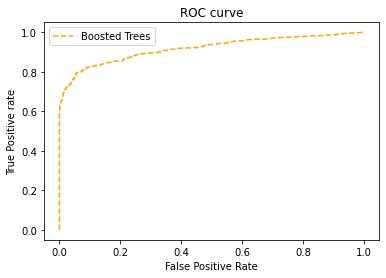

AUC Score: 0.918


In [26]:
random_forest(features, y.ravel(), nEstimator)